In [11]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [12]:
import matplotlib.pyplot as plt
import torch
from sdm.models import S2Dataset

In [13]:
from torchvision.transforms import v2
img_transforms = v2.Compose([
    # Rotate
    v2.RandomRotation(30, expand=True),
    # Flip
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    # Affine
    v2.RandomAffine(10, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
    v2.Resize((304, 304), antialias=True),
])

In [14]:
# import dataloader and split into train and validation
from ast import Sub
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split

dataset = S2Dataset(transforms=img_transforms)
n_input_bands = len(dataset.input_bands)

validation_split = .2

all_indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(all_indices, test_size=validation_split, random_state=42)


batch_size = 32

# Train on a subset - this is useful for experimenting and I will train on full dataset when I am happy with the model
train_dataset = Subset(S2Dataset(img_transforms), train_indices)
test_dataset = Subset(S2Dataset(), test_indices)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sdm.models import VegCNN
# set mac m1 device
device = torch.device('mps')




# Initialize the model, loss, and optimizer
model = VegCNN(n_input_bands)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = model.to(device)
criterion = criterion.to(device)

loss_results = []

# Training loop
n_epochs = 10  # Number of epochs
early_stop = 3  # Stop if the validation loss does not improve after 5 epochs
best_val_loss = 1e10  # Set initial best validation loss to infinity

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0
    for i, (inputs, target, spatial_json) in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch {epoch}/{n_epochs} Batch {i+1}/{len(train_dataloader)} Loss: {loss.item():.4f}")
    avg_loss_train = epoch_loss/len(train_dataloader)
    print(f"Epoch {epoch}/{n_epochs} Loss: {avg_loss_train}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for i, (inputs, target, spatial_json) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            target = target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, target)
            epoch_loss += loss.item()
        avg_loss_val = epoch_loss/len(test_dataloader)
        
        print(f"Epoch {epoch}/{n_epochs} Validation Loss: {avg_loss_val}")
    
    loss_results.append({'train': avg_loss_train, 'val': avg_loss_val})

    scheduler.step()
    # Early stopping
    if avg_loss_val < best_val_loss:
        best_val_loss = avg_loss_val
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop:
            print('Early stopping!')
            break

# Save the model
# torch.save(model.state_dict(), "simple_cnn_model.pth")


Epoch 1/10 Batch 1/31 Loss: 1.0752
Epoch 1/10 Batch 2/31 Loss: 0.8845
Epoch 1/10 Batch 3/31 Loss: 0.7252
Epoch 1/10 Batch 4/31 Loss: 0.6053
Epoch 1/10 Batch 5/31 Loss: 0.5066
Epoch 1/10 Batch 6/31 Loss: 0.4123
Epoch 1/10 Batch 7/31 Loss: 0.3324
Epoch 1/10 Batch 8/31 Loss: 0.2693
Epoch 1/10 Batch 9/31 Loss: 0.2614
Epoch 1/10 Batch 10/31 Loss: 0.2641
Epoch 1/10 Batch 11/31 Loss: 0.1828
Epoch 1/10 Batch 12/31 Loss: 0.1708
Epoch 1/10 Batch 13/31 Loss: 0.1657
Epoch 1/10 Batch 14/31 Loss: 0.1590
Epoch 1/10 Batch 15/31 Loss: 0.1212
Epoch 1/10 Batch 16/31 Loss: 0.1603
Epoch 1/10 Batch 17/31 Loss: 0.1306
Epoch 1/10 Batch 18/31 Loss: 0.1749
Epoch 1/10 Batch 19/31 Loss: 0.1204
Epoch 1/10 Batch 20/31 Loss: 0.1514
Epoch 1/10 Batch 21/31 Loss: 0.1529
Epoch 1/10 Batch 22/31 Loss: 0.1507
Epoch 1/10 Batch 23/31 Loss: 0.1284
Epoch 1/10 Batch 24/31 Loss: 0.1110
Epoch 1/10 Batch 25/31 Loss: 0.1308
Epoch 1/10 Batch 26/31 Loss: 0.1345
Epoch 1/10 Batch 27/31 Loss: 0.1618
Epoch 1/10 Batch 28/31 Loss: 0.1551
E

<Axes: >

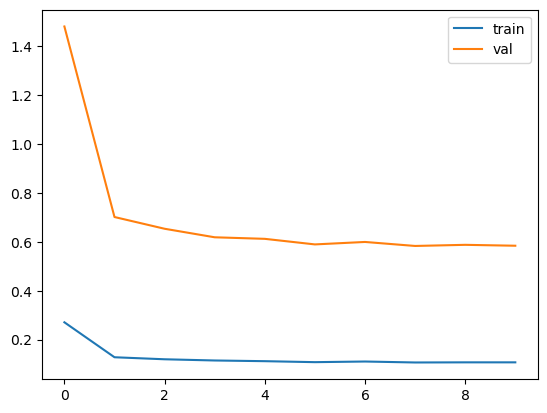

In [16]:
import pandas as pd
loss_df =  pd.DataFrame(loss_results)
loss_df.plot()

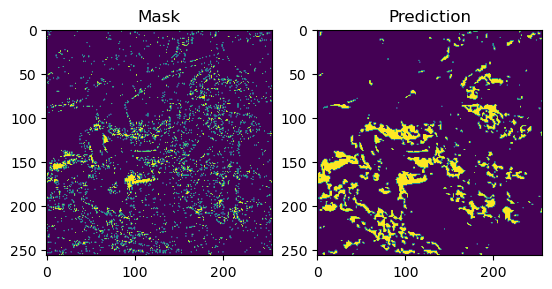

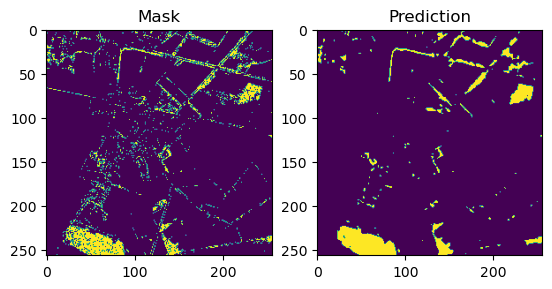

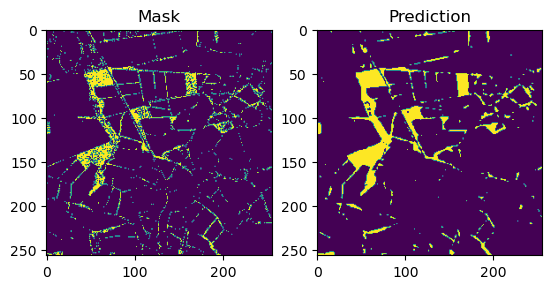

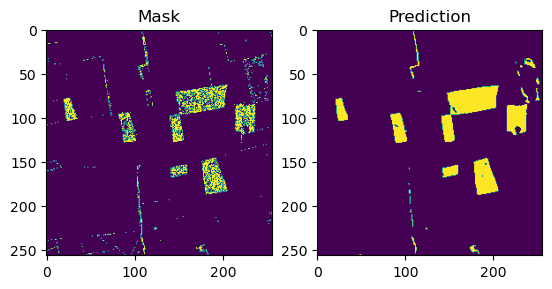

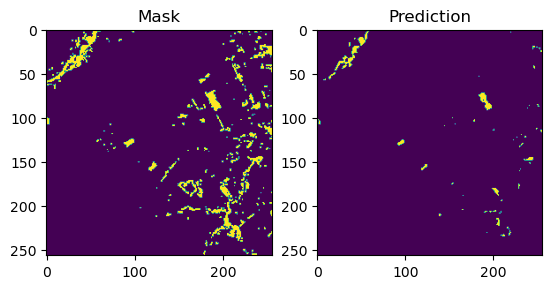

In [20]:
from sdm.models import SpatialTransformer, plot_predictions

model.eval()

# Make some predictions and plot the mask and the prediction in sub plots
results = []
with torch.no_grad():
    for i, (inputs, target, spatial_json) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)

        target_np = target.cpu().numpy()
        prediction_np = outputs.cpu().numpy()

        # iterate over the batch
        for i in range(len(target_np)):
            results.append({"target": target_np[i], "prediction": prediction_np[i], "transform": spatial_json[i]})
        


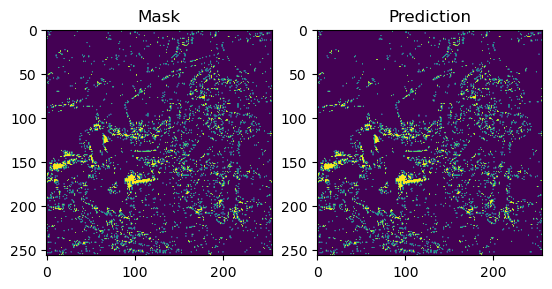

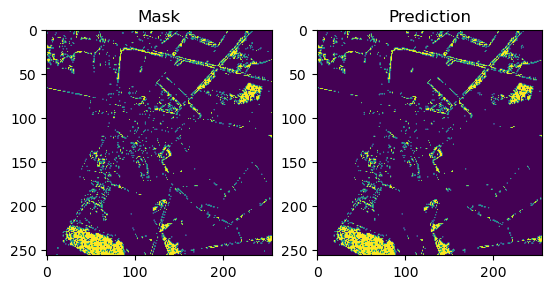

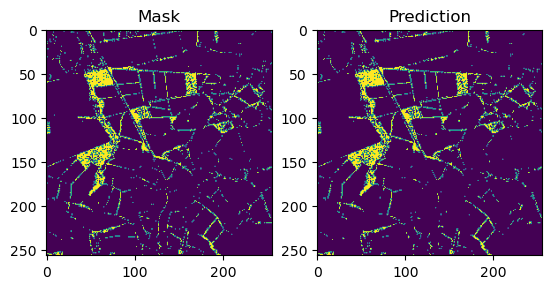

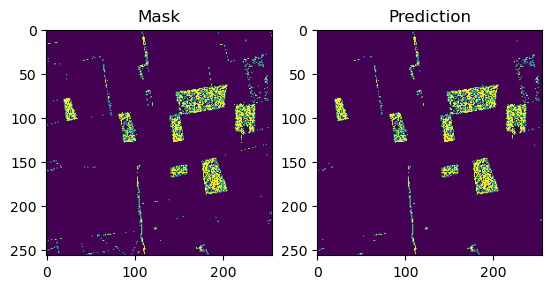

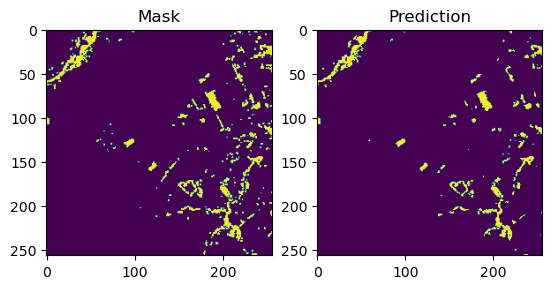

In [24]:
for i in range(5):
    pred_01 = results[i]["prediction"] > 0.1
    plot_predictions(results[i]["target"], pred_01 * results[i]["target"])

In [18]:
import json

predictions = []
for result in results:
    transform_args  = json.loads(result["transform"])
    transformer = SpatialTransformer(**transform_args)
    prediction = transformer(result["prediction"])

    predictions.append(prediction)

    

In [1]:
# Save the model
torch.save(model, "models/is-veg-cnn.pth")

NameError: name 'torch' is not defined